<a href="https://colab.research.google.com/github/odus05/Image_Retrieval/blob/master/lfw_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

In [1]:
import numpy as np
import pandas as pd
import os
import time
import cv2
from cv2 import imread, resize 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.models import Model, load_model
import tensorflow.python.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard
s = K.get_session()
import tarfile
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

### Loading Dataset

In [0]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "lfw_attributes.txt"

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "lfw-deepfunneled.tgz"

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "lfw.tgz"

In [0]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.array(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [0]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):
    
    #     #download if not exists
#     if not os.path.exists(os.path.join('./data', images_name)):
#         print("images not found, donwloading...")
#         os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
#         print("extracting...")
#         os.system("tar xvzf tmp.tgz && rm tmp.tgz")
#         os.system("mv ./lfw-deepfunneled ./data/lfw-deepfunneled")
#         print("done")
# #         assert os.path.exists(images_name)
        
    if not os.path.exists(RAW_IMAGES_NAME):
        print("raw_imges_name not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O lfw.tgz")
        print("extracting...")
#         os.system("tar xvzf tmp.tgz && rm tmp.tgz")
#         os.system("mv ./lfw ./data/lfw")
        print("done")
# #         assert os.path.exists(images_name)
        
    if not os.path.exists(ATTRS_NAME):
        print("attributes not found, downloading...")
        os.system("wget  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"%ATTRS_NAME)
        # os.system("mv ./lfw_attributes.txt ./data/lfw_attributes.txt")
        print("done")

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [6]:
# Loading and normalizing [Might take some time]
X, attr = load_lfw_dataset(use_raw=True, dimx=32,dimy=32)

raw_imges_name not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [0]:
X = X.astype('float32') / 255.0
# X = X.reshape(X, (len(X), 32, 32, 1))
img_shape = X.shape[1:]
x_train, x_test = train_test_split(X, test_size=0.1, random_state=42)

In [0]:
def apply_gaussian_noise(X, sigma=0.1):
  noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
  return X + noise

In [0]:
x_train_noise = apply_gaussian_noise(x_train)
x_test_noise = apply_gaussian_noise(x_test)

In [0]:
def show_image(x):
  plt.imshow(np.clip(x, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


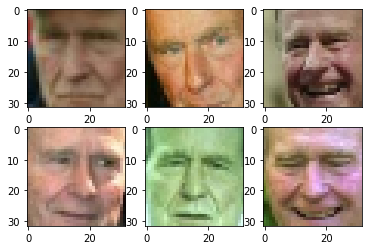

In [0]:
# Checking out some original images
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])
print("X shape:",X.shape)
print("attr shape:",attr.shape)

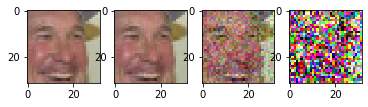

In [0]:
# Clipping the images for showing
plt.subplot(1,4,1)
show_image(x_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(x_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(x_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(x_train[:1],sigma=0.5)[0])

### Making a Deep Autoencoder using Feedforward Neural Network


In [0]:
img_shape

(32, 32, 3)

In [0]:
def train_model():
    input_img = Input(shape=img_shape)
    x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)    
    x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
    encoder = MaxPooling2D((2,2), padding='same', name='encoder')(x)
    
    x = Conv2D(8, (3,3), activation='relu', padding='same')(encoder)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoder = Conv2D(3, (3,3), activation='sigmoid', padding='same', name='decoder')(x)
    
    autoencoder = Model(input_img, decoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(x_train_noise, x_train,
              epochs=20,
              batch_size=128,
              shuffle=True,
              validation_data=(x_test_noise, x_test),
              callbacks=[TensorBoard(log_dir='/tmp/', histogram_freq=0, write_graph=True)])
    autoencoder.save('autoencoder.h5')

    return history

Train on 11828 samples, validate on 1315 samples
Epoch 1/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0318 - val_loss: 0.0198
Epoch 2/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0169 - val_loss: 0.0150
Epoch 3/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0140 - val_loss: 0.0130
Epoch 4/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0124 - val_loss: 0.0118
Epoch 5/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0115 - val_loss: 0.0110
Epoch 6/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0109 - val_loss: 0.0105
Epoch 7/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0104 - val_loss: 0.0102
Epoch 8/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0101 - val_loss: 0.0100
Epoch 9/20
11828/11828 [==============================] - 23s 2ms/sample - loss: 0.0099 - val_l

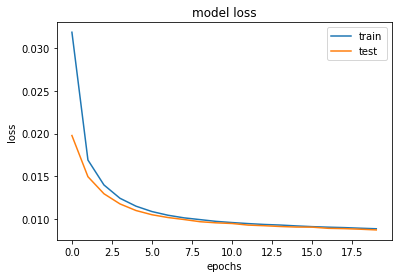

In [0]:
history = train_model()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','test'], loc='best')
plt.show()

In [0]:
print('Loading Model :')
t0 = time.time()
autoencoder = load_model('autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
decoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('decoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)

Loading Model :
Model loaded in:  3.073219060897827


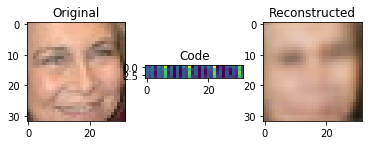

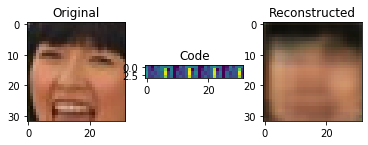

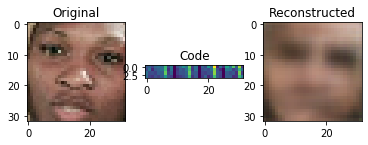

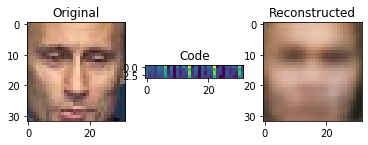

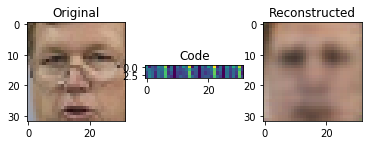

In [0]:
def visualize(img, encoder, decoder):
  """Draws original, encoded and decoded images"""
  # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input

  code = encoder.predict(img[None])[0]
  reco = decoder.predict(img[None])[0]

  plt.subplot(1,3,1)
  plt.title('Original')
  show_image(img)

  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//2,-1]))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  show_image(reco)
  plt.show()

for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [0]:
# Evaluation using noisy input
denoising_mse = autoencoder.evaluate(x_test_noisy, X_test, verbose=0)
print("Final MSE:", denoising_mse)

plt.subplot(1,3,1)
plt.imshow(X_test[0])
plt.subplot(1,3,2)
plt.imshow(encoder.predict(X_test[0]))
plt.subplot(1,3,3)
plt.imshow(decoder.predict(X_test[0]))

### Image_Retrieval

In [0]:
imges = X_train

# Hashing the image with encoder
codes = encoder.predict(images)

def show_image(x):
    plt.im
    
# Fitting the codes
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric='euclidean')
nei_clf.fit(codes)

def get_similar(image, n_neighbors=5):
    assert image.ndim==3, "image must be [batch, height, width, 3]"
    code = encoder.predict(image[None])
    (distances,),(idx,) = nei_clf.kneighbors(code, n_neighbors=n_neighbors)
    return distances, images[idx]

def show_similar(image):
    